## IMPORTING THE REQUIRED LIBRARIES AND DATA

In [56]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Display all columns in one line
pd.set_option('display.max_columns', None)   # show all columns
pd.set_option('display.width', 1000)         # set a wide width to avoid wrapping


# Load CSV
df_csv = pd.read_csv('tn.movie_budgets.csv\\tn.movie_budgets.csv')

# Load SQLite
conn = sqlite3.connect('im.db\im.db')


In [57]:
# Check CSV columns and first 5 rows
print("CSV columns:")
print(df_csv.columns.tolist())

print("\nCSV sample data:")
print(df_csv.head())

CSV columns:
['id', 'release_date', 'movie', 'production_budget', 'domestic_gross', 'worldwide_gross']

CSV sample data:
   id  release_date                                        movie production_budget domestic_gross worldwide_gross
0   1  Dec 18, 2009                                       Avatar      $425,000,000   $760,507,625  $2,776,345,279
1   2  May 20, 2011  Pirates of the Caribbean: On Stranger Tides      $410,600,000   $241,063,875  $1,045,663,875
2   3   Jun 7, 2019                                 Dark Phoenix      $350,000,000    $42,762,350    $149,762,350
3   4   May 1, 2015                      Avengers: Age of Ultron      $330,600,000   $459,005,868  $1,403,013,963
4   5  Dec 15, 2017            Star Wars Ep. VIII: The Last Jedi      $317,000,000   $620,181,382  $1,316,721,747


In [58]:
# Check available tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("SQLite tables:")
print(tables)
 

SQLite tables:
            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


In [59]:
# Inspect movie_basics table
df_movie_basics = pd.read_sql_query("SELECT * FROM movie_basics;", conn)

print("\nFirst 5 rows of movie_basics:")
print(df_movie_basics)

print("\nColumns in movie_basics:")
print(df_movie_basics.columns.tolist())



First 5 rows of movie_basics:
         movie_id                                primary_title                               original_title  start_year  runtime_minutes                genres
0       tt0063540                                    Sunghursh                                    Sunghursh        2013              175    Action,Crime,Drama
1       tt0066787              One Day Before the Rainy Season                              Ashad Ka Ek Din        2019              114       Biography,Drama
2       tt0069049                   The Other Side of the Wind                   The Other Side of the Wind        2018              122                 Drama
3       tt0069204                              Sabse Bada Sukh                              Sabse Bada Sukh        2018              NaN          Comedy,Drama
4       tt0100275                     The Wandering Soap Opera                        La Telenovela Errante        2017               80  Comedy,Drama,Fantasy
...           .

In [60]:
# Load movie_akas
df_movie_akas = pd.read_sql_query("SELECT movie_id, title FROM movie_akas", conn)

print(df_movie_akas)

         movie_id                                    title
0       tt0369610                            Джурасик свят
1       tt0369610                        Jurashikku warudo
2       tt0369610  Jurassic World: O Mundo dos Dinossauros
3       tt0369610                  O Mundo dos Dinossauros
4       tt0369610                           Jurassic World
...           ...                                      ...
331698  tt9827784                       Sayonara kuchibiru
331699  tt9827784                            Farewell Song
331700  tt9880178                              La atención
331701  tt9880178                              La atención
331702  tt9880178                            The Attention

[331703 rows x 2 columns]


## DATA CLEANING

In [ ]:
# Check missing values
print("Missing values in CSV:")
print(df_csv.isnull().sum())

print("\nMissing values in movie_basics:")
print(df_movie_basics.isnull().sum())

# Check duplicates
print("\nDuplicate movie titles in CSV:")
print(df_csv['movie'].duplicated().sum())

print("\nDuplicate primary_title in movie_basics:")
print(df_movie_basics['primary_title'].duplicated().sum())

# Clean numeric columns
df_csv['production_budget'] = df_csv['production_budget'].replace('[\$,]', '', regex=True)
df_csv['production_budget'] = pd.to_numeric(df_csv['production_budget'], errors='coerce')

df_csv['worldwide_gross'] = df_csv['worldwide_gross'].replace('[\$,]', '', regex=True)
df_csv['worldwide_gross'] = pd.to_numeric(df_csv['worldwide_gross'], errors='coerce')

# Clean movie titles: strip spaces, lowercase, remove punctuation
df_csv['movie_clean'] = ( df_csv['movie'].str.strip().str.lower().str.replace(r"[^\w\s]", "", regex=True))
df_movie_basics['primary_title_clean'] = (df_movie_basics['primary_title'].str.strip().str.lower().str.replace(r"[^\w\s]", "", regex=True))
# Clean movie_akas titles
df_movie_akas['clean_aka_title'] = (df_movie_akas['title'].str.strip().str.lower().str.replace(r"[^\w\s]", "", regex=True))

# Clean movie_id type
df_movie_basics['movie_id'] = df_movie_basics['movie_id'].astype(str)
df_movie_akas['movie_id'] = df_movie_akas['movie_id'].astype(str)




Missing values in CSV:
id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

Missing values in movie_basics:
movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

Duplicate movie titles in CSV:
84

Duplicate primary_title in movie_basics:
10073


In [62]:
# Merge on primary_title_clean
df_merge_primary = pd.merge(
    df_csv,
    df_movie_basics[['movie_id', 'primary_title', 'genres', 'start_year', 'primary_title_clean']],
    left_on='movie_clean',
    right_on='primary_title_clean',
    how='inner'
)


In [63]:
# Find unmatched movies after primary_title merge
matched_movie_titles = df_merge_primary['movie'].unique()
df_csv_unmatched = df_csv[~df_csv['movie'].isin(matched_movie_titles)]

print(f"Number of unmatched movies after primary_title merge: {df_csv_unmatched.shape[0]}")

Number of unmatched movies after primary_title merge: 3309


In [64]:
# Merge unmatched movies with AKAS
df_merge_akas = pd.merge(
    df_csv_unmatched,
    df_movie_akas[['movie_id', 'clean_aka_title']],
    left_on='movie_clean',
    right_on='clean_aka_title',
    how='inner'
)

# Bring in genres and start_year
df_merge_akas_full = pd.merge(
    df_merge_akas,
    df_movie_basics[['movie_id', 'genres', 'start_year']],
    on='movie_id',
    how='left'
)

# Concatenate both DataFrames
df_merged_combined = pd.concat([df_merge_primary, df_merge_akas_full], ignore_index=True)

# Drop duplicates based on 'movie'
df_merged_combined = df_merged_combined.drop_duplicates(subset='movie', keep='first')

# Show final merged result
print("\nFINAL Merged DataFrame shape:", df_merged_combined.shape)
print("\nSample merged data with genres:")
print(df_merged_combined[['movie', 'genres', 'production_budget', 'worldwide_gross']].head(5))


# Print unmatched movie titles:
csv_titles = set(df_csv['movie_clean'].unique())
primary_titles = set(df_movie_basics['primary_title_clean'].unique())
aka_titles = set(df_movie_akas['clean_aka_title'].unique())

total_db_titles = primary_titles.union(aka_titles)

unmatched_movies = csv_titles - total_db_titles
print(f"\nNumber of completely unmatched movies: {len(unmatched_movies)}")
if len(unmatched_movies) > 0:
    print("Example unmatched movies:", list(unmatched_movies)[:10])



FINAL Merged DataFrame shape: (2595, 13)

Sample merged data with genres:
                                         movie                    genres  production_budget  worldwide_gross
0                                       Avatar                    Horror          425000000       2776345279
1  Pirates of the Caribbean: On Stranger Tides  Action,Adventure,Fantasy          410600000       1045663875
2                                 Dark Phoenix   Action,Adventure,Sci-Fi          350000000        149762350
3                      Avengers: Age of Ultron   Action,Adventure,Sci-Fi          330600000       1403013963
4                       Avengers: Infinity War   Action,Adventure,Sci-Fi          300000000       2048134200

Number of completely unmatched movies: 3103
Example unmatched movies: ['black water transit', 'bend it like beckham', 'la guerre du feu', 'my cousin vinny', 'the thousand miles', 'seed of chucky', 'men women and children', 'artie langes beer league', 'osama', 'urbania']

## ANALYSIS

In [65]:
pd.set_option('display.float_format', '{:,.0f}'.format)
# Basic statistics
print("\nProduction Budget stats:")
print(df_merged_combined['production_budget'].describe())

print("\nWorldwide Gross stats:")
print(df_merged_combined['worldwide_gross'].describe())



Production Budget stats:
count         2,595
mean     35,288,796
std      48,457,889
min           1,400
25%       5,000,000
50%      18,000,000
75%      42,000,000
max     425,000,000
Name: production_budget, dtype: float64

Worldwide Gross stats:
count           2,595
mean      104,858,154
std       204,682,209
min                 0
25%         2,468,476
50%        30,601,801
75%       106,891,702
max     2,776,345,279
Name: worldwide_gross, dtype: float64


## PROFITABLE GENRES

### Checking the ratio of worldwide gross and production budget

In [66]:
# Add gross-to-budget ratio
df_merged_combined['gross_to_budget_ratio'] = df_merged_combined['worldwide_gross'] / df_merged_combined['production_budget']


df_profitable = df_merged_combined[df_merged_combined['worldwide_gross'] > 0]

# Group by genre (explode multi-genre entries)
df_profitability = (
    df_profitable.dropna(subset=['genres', 'gross_to_budget_ratio'])
    .assign(genres=df_profitable['genres'].str.split(','))
    .explode('genres')
    .groupby('genres')
    .gross_to_budget_ratio
    .median()
    .sort_values(ascending=False)
)

print("\nMedian gross-to-budget ratio per genre:")
print(df_profitability)



Median gross-to-budget ratio per genre:
genres
News          3
Animation     3
Horror        3
Mystery       3
Sci-Fi        2
Adventure     2
Comedy        2
Action        2
Romance       2
Thriller      2
Fantasy       2
Family        2
Music         2
Biography     2
Drama         2
Crime         2
Documentary   1
Sport         1
Western       1
History       1
Musical       1
War           1
Name: gross_to_budget_ratio, dtype: float64


## Mean production budget, mean worldwide gross, mean profit per genre:

In [67]:
# Exclude rows with worldwide_gross == 0
df_profitable = df_merged_combined[df_merged_combined['worldwide_gross'] > 0]

# grouping
df_mean_budget_gross_profit = (
    df_profitable.dropna(subset=['genres', 'production_budget', 'worldwide_gross'])
    .assign(genres=df_profitable['genres'].str.split(','))
    .explode('genres')
    .groupby('genres')
    .agg(
        mean_production_budget=('production_budget', 'mean'),
        mean_worldwide_gross=('worldwide_gross', 'mean'),
        movie_count=('movie', 'count')
    )
)

# mean profit column
df_mean_budget_gross_profit['mean_profit'] = (df_mean_budget_gross_profit['mean_worldwide_gross']- df_mean_budget_gross_profit['mean_production_budget'])

# Sort by mean_profit descending
df_mean_budget_gross_profit = df_mean_budget_gross_profit.sort_values(by='mean_profit', ascending=False)

# Display the result
print("\nMean production budget, mean worldwide gross, mean profit per genre:")
print(df_mean_budget_gross_profit)



Mean production budget, mean worldwide gross, mean profit per genre:
             mean_production_budget  mean_worldwide_gross  movie_count  mean_profit
genres                                                                             
Animation                82,571,971           299,401,504          136  216,829,533
Adventure                94,451,028           307,590,292          437  213,139,264
Sci-Fi                   81,264,575           289,128,409          171  207,863,834
Action                   73,085,014           215,559,859          553  142,474,845
Fantasy                  75,874,603           206,254,628          156  130,380,025
Family                   53,708,906           145,714,061          139   92,005,154
Comedy                   36,521,131           116,308,017          693   79,786,886
Thriller                 31,203,550            96,985,846          350   65,782,296
Mystery                  25,344,627            87,913,904          161   62,569,277
Horror

## PLOTTING

### Median Gross to Budget ratio per genre

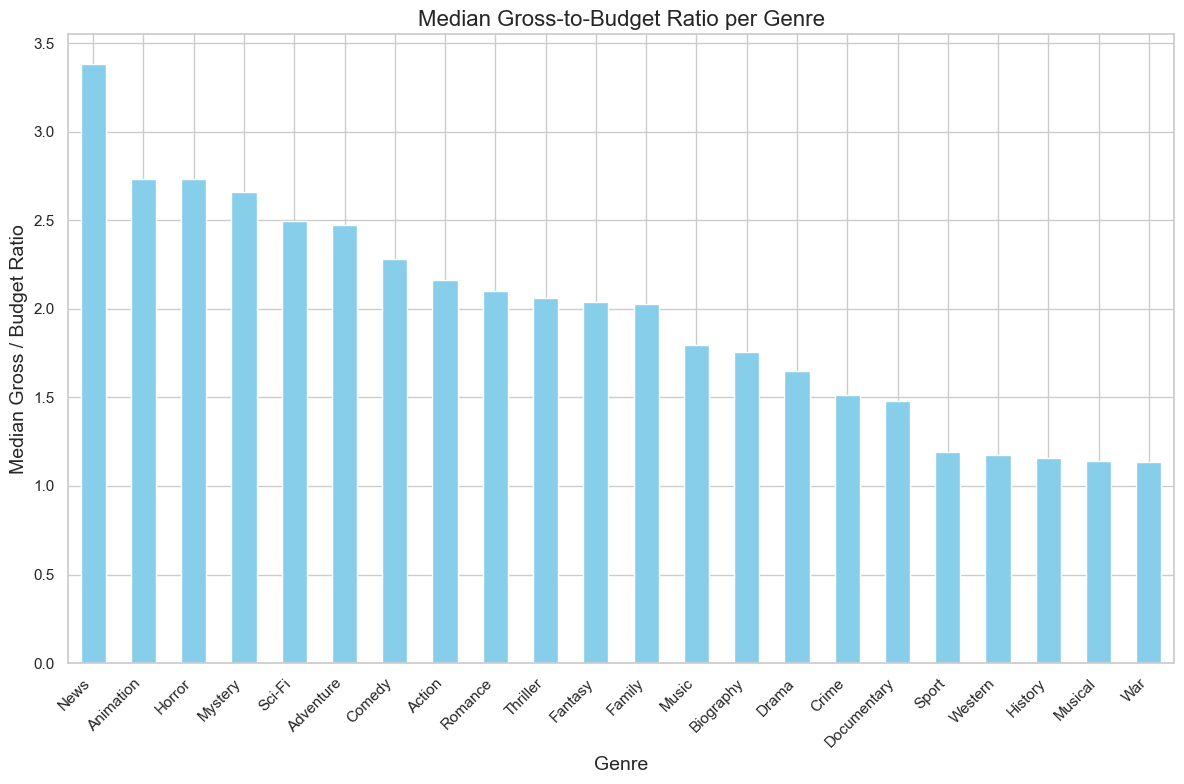

In [68]:
# Set plot style
sns.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (12, 8), 'axes.titlesize': 16, 'axes.labelsize': 14})

# -------- PLOT 1: Median Gross-to-Budget Ratio --------
plt.figure(figsize=(12, 8))
df_profitability.plot(kind='bar', color='skyblue')
plt.title('Median Gross-to-Budget Ratio per Genre')
plt.ylabel('Median Gross / Budget Ratio')
plt.xlabel('Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



### Mean Profit per genre

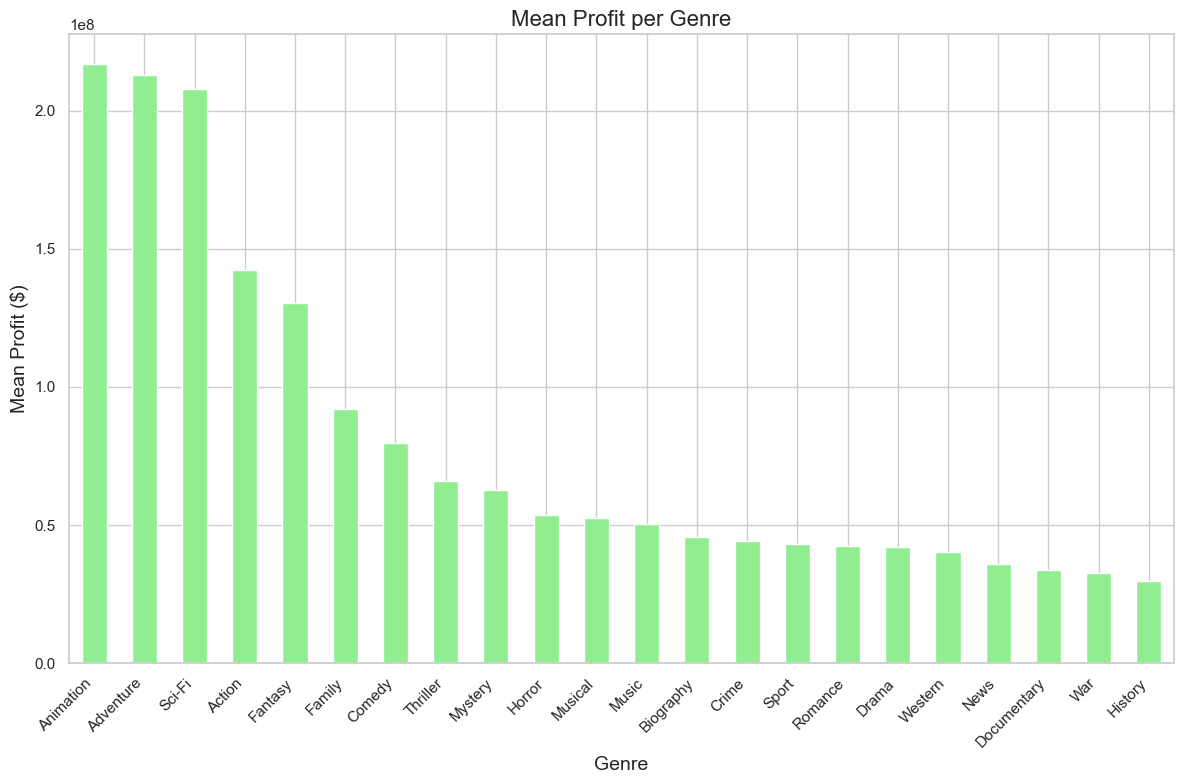

In [69]:
# -------- PLOT 2: Mean Profit per Genre --------
plt.figure(figsize=(12, 8))
df_mean_budget_gross_profit['mean_profit'].plot(kind='bar', color='lightgreen')
plt.title('Mean Profit per Genre')
plt.ylabel('Mean Profit ($)')
plt.xlabel('Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Mean budget vs Mean Gross per genre

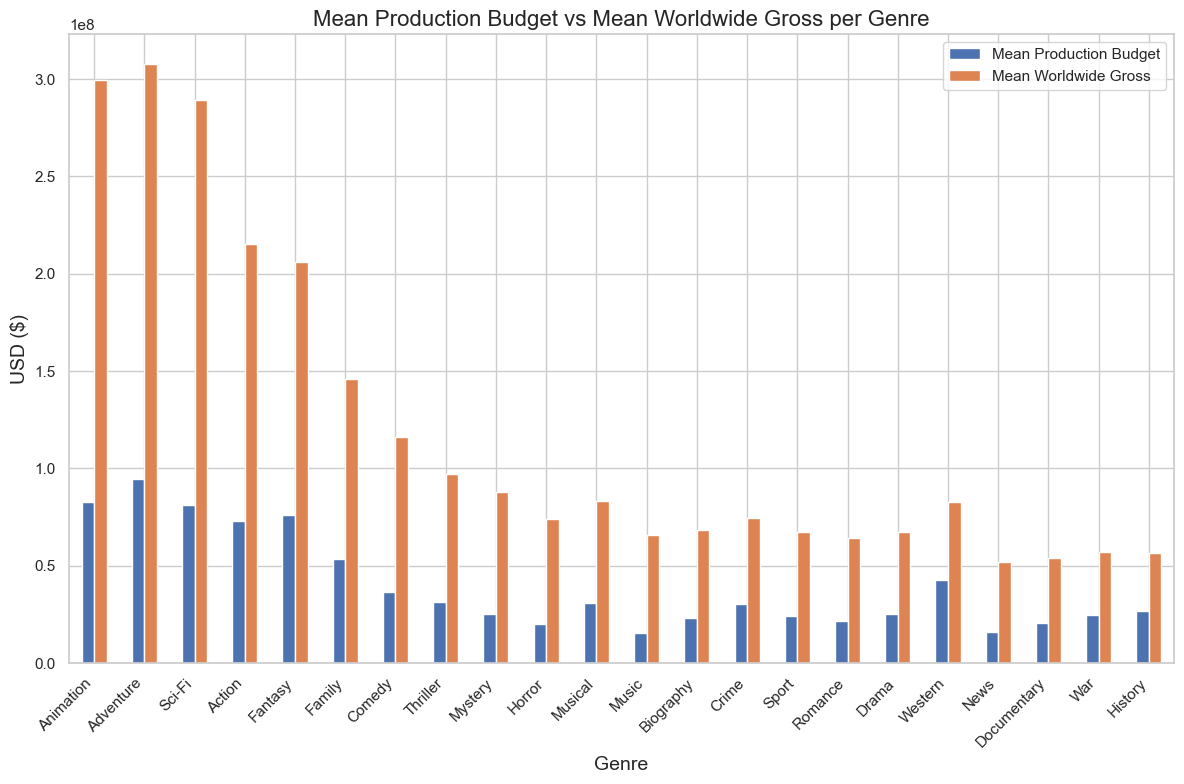

In [70]:
# -------- PLOT 3: Mean Budget vs Mean Gross per Genre --------
df_mean_budget_gross_profit[['mean_production_budget', 'mean_worldwide_gross']].plot(kind='bar', stacked=False)
plt.title('Mean Production Budget vs Mean Worldwide Gross per Genre')
plt.ylabel('USD ($)')
plt.xlabel('Genre')
plt.xticks(rotation=45, ha='right')
plt.legend(['Mean Production Budget', 'Mean Worldwide Gross'])
plt.tight_layout()
plt.show()
